# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
splitter=transcript.time >= 24*7*3
test_transcript=transcript[splitter].copy()
transcript=transcript[~splitter]

portfolio=portfolio.set_index('id')
portfolio.index.rename('offer_id', inplace=True)

dummies=portfolio.channels.apply(lambda x: pd.Series(len(x)*[1], x)).fillna(0)
portfolio=pd.concat([portfolio.drop('channels', axis=1), dummies], axis=1)
portfolio.sort_values(['offer_type','reward','difficulty'])

,reward,difficulty,duration,offer_type,email,mobile,social,web
offer_id,,,,,,,,
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1.0,1.0,1.0,1.0
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1.0,1.0,1.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1.0,1.0,1.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1.0,1.0,1.0,1.0
2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1.0,1.0,0.0,1.0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1.0,1.0,1.0,1.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1.0,0.0,0.0,1.0
3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1.0,1.0,0.0,1.0


In [3]:
portfolio.groupby(['reward','difficulty','offer_type']).mean()

duration  email  mobile  social  web
reward difficulty offer_type                                         
0      0          informational       3.5    1.0     1.0     0.5  0.5
2      10         discount            8.5    1.0     1.0     0.5  1.0
3      7          discount            7.0    1.0     1.0     1.0  1.0
5      5          bogo                6.0    1.0     1.0     0.5  1.0
       20         discount           10.0    1.0     0.0     0.0  1.0
10     10         bogo                6.0    1.0     1.0     1.0  0.5

In [4]:
profile=profile.set_index('id')
dates=profile.became_member_on.apply(lambda x: dt.strptime(str(x), '%Y%m%d'))
profile.became_member_on=dates
profile['account_age']=np.round((dt.now()-profile.became_member_on).apply(lambda x: x.days)/365)
profile.head()

,gender,age,became_member_on,income,account_age
id,,,,,
68be06ca386d4c31939f3a4f0e3dd783,None,118,2017-02-12,NaN,4.0
0610b486422d4921ae7d2bf64640c50b,F,55,2017-07-15,112000.0,4.0
38fe809add3b4fcf9315a9694bb96ff5,None,118,2018-07-12,NaN,3.0
78afa995795e4d85b5d9ceeca43f5fef,F,75,2017-05-09,100000.0,4.0
a03223e636434f42ac4c3df47e8bac43,None,118,2017-08-04,NaN,4.0


<AxesSubplot:xlabel='age', ylabel='Density'>

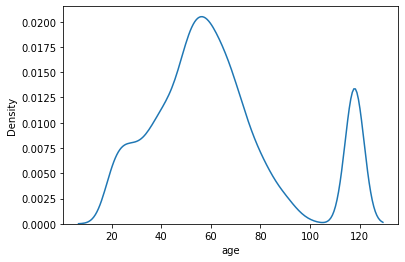

In [5]:
sns.kdeplot(profile.age)

In [6]:
profile.loc[profile.age > 105,'age']=np.nan

In [7]:
profile.isnull().sum()

gender              2175
age                 2175
became_member_on       0
income              2175
account_age            0
dtype: int64

There's about 2000 people for whom we have basically no user data. We'll just drop these for most applications.

In [8]:
full_profile=profile.copy()
profile=profile.dropna()

In [9]:
transactions=transcript[transcript.event=='transaction'].copy()
transactions.value=transactions.value.apply(lambda x: x['amount'])
transactions.set_index('person', inplace=True)
transactions.index.name='id'

<AxesSubplot:xlabel='time'>

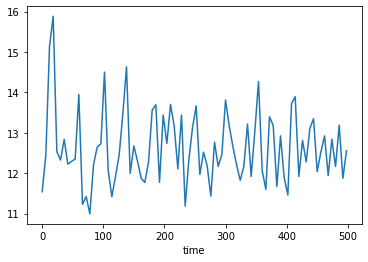

In [10]:
transactions.groupby('time').value.mean().plot()

In [11]:
spend=transactions.groupby(level=0).sum().value
spend.name='spend'

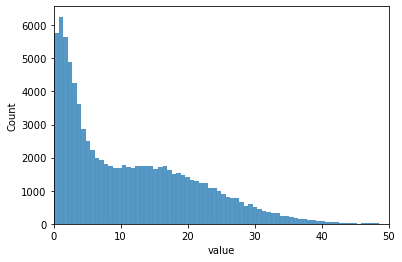

In [12]:
g=sns.histplot(transactions.value)
g.set_xlim(0,50);

In [13]:
profile=profile.merge(spend, how='left', left_index=True, right_index=True).sort_values('spend', ascending=False).fillna(0)

In [14]:
profile.head()

,gender,age,became_member_on,income,account_age,spend
id,,,,,,
ae6f43089b674728a50b8727252d3305,F,36.0,2017-05-21,71000.0,4.0,1257.06
ad1f0a409ae642bc9a43f31f56c130fc,M,66.0,2017-08-27,80000.0,4.0,1236.32
dce784e26f294101999d000fad9089bb,F,53.0,2016-02-03,110000.0,5.0,1125.96
4d0ebb94a5a94fe6afd9350c7b1477e4,M,81.0,2016-01-16,117000.0,5.0,1094.19
7d7f271652d244f78b97c73cd734c553,M,37.0,2016-03-24,98000.0,5.0,1085.34


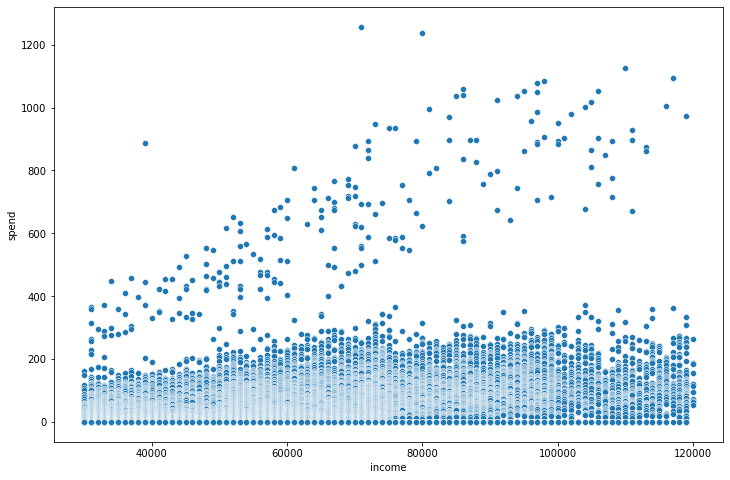

In [15]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=profile, x='income', y='spend');

In [16]:
big_spenders=profile.dropna()[profile.dropna().spend >= transactions.value.mean()*30]

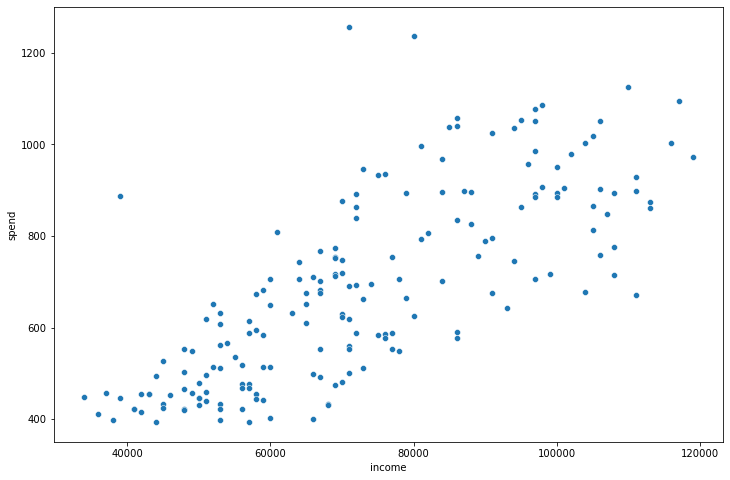

In [17]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=big_spenders, x='income', y='spend');

In [18]:
profile['big_spender']=[ x in big_spenders.index for x in profile.index]

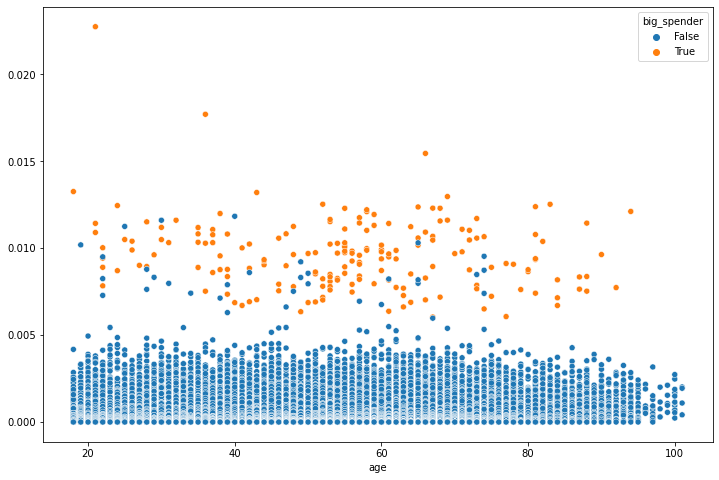

In [19]:
plt.subplots(figsize = (12,8))
sns.scatterplot(y=profile.spend/profile.income, x=profile.age, hue=profile.big_spender);

In [20]:
def pull_event(event, df=transcript, parser=lambda x: x['offer id'], label='offer_id'):
    events=df[df.event==event].copy()
    events[label]=events.value.apply(parser)
    return events.drop(['value', 'event'], axis=1)

offers_made=pull_event('offer received')

In [21]:
offers_recieved=offers_made.merge(portfolio, left_on='offer_id', right_index=True)
offers_made=offers_made.groupby(['offer_id','time']).count().person
offers_made.name='count'

offers_made.head(10)

offer_id                          time
0b1e1539f2cc45b7b9fa7c272da2e1d7  0       1297
                                  168     1245
                                  336     1322
                                  408     1269
2298d6c36e964ae4a3e7e9706d1fb8c2  0       1221
                                  168     1250
                                  336     1301
                                  408     1274
2906b810c7d4411798c6938adc9daaa5  0       1257
                                  168     1270
Name: count, dtype: int64

<AxesSubplot:xlabel='time', ylabel='Count'>

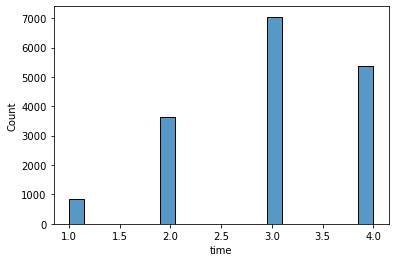

In [22]:
sns.histplot(offers_recieved.groupby('person').time.count())

In [23]:
offers_completed=pull_event('offer completed', parser=lambda x: x['offer_id'])
offers_completed=offers_completed.merge(portfolio.reward, left_on='offer_id', right_index=True)

offers_completed.head()

,person,time,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2
12764,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2
12786,24115a61df25473e84a8a03f3c98de1a,0,2906b810c7d4411798c6938adc9daaa5,2
12826,2481f1fcfbcb4b288e5a03af02d95373,0,2906b810c7d4411798c6938adc9daaa5,2
13183,a45b69f1c8554ae7af83e74426ca437a,0,2906b810c7d4411798c6938adc9daaa5,2


In [24]:
transactions=transactions.reset_index().merge(offers_completed[['person','time', 'reward']], 
                                 left_on=['id','time'], right_on=['person','time'], 
                                 how='left').set_index('id').drop('person', axis=1).fillna(0)

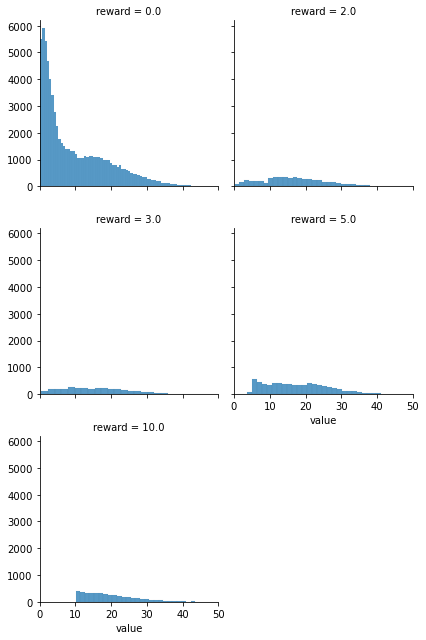

In [25]:
g=sns.FacetGrid(transactions, col="reward", col_wrap=2)
g.map(sns.histplot, 'value')
g.set(xlim=(0,50))

In [26]:
max_rewards=offers_recieved.groupby('person').reward.sum()
max_rewards.name='max_reward'
number_completed=(transactions.reward > 0).groupby('id').sum()
number_completed.name='#_completed'
number_transactions=transactions.groupby('id').time.count()
number_transactions.name='#_transactions'
rewards=offers_completed.groupby('person').reward.sum()
rewards.head()

person
0009655768c64bdeb2e877511632db8f    5
0011e0d4e6b944f998e987f904e8c1e5    3
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    8
003d66b6608740288d6cc97a6903f4f0    2
Name: reward, dtype: int64

In [27]:
idx=profile.index

In [28]:
profile=pd.concat([profile, rewards, max_rewards, number_completed, number_transactions], axis=1).fillna(0).loc[idx]

In [29]:
reward_profile=profile.groupby(['reward', 'max_reward']).spend.mean().apply(lambda x: np.log(x))
reward_profile.name='log spend'
reward_profile=reward_profile.reset_index()

In [30]:
profile.head()

,gender,age,became_member_on,income,account_age,spend,big_spender,reward,max_reward,#_completed,#_transactions
id,,,,,,,,,,,
ae6f43089b674728a50b8727252d3305,F,36.0,2017-05-21 00:00:00,71000.0,4.0,1257.06,True,17.0,17.0,3.0,13.0
ad1f0a409ae642bc9a43f31f56c130fc,M,66.0,2017-08-27 00:00:00,80000.0,4.0,1236.32,True,15.0,25.0,3.0,4.0
dce784e26f294101999d000fad9089bb,F,53.0,2016-02-03 00:00:00,110000.0,5.0,1125.96,True,9.0,9.0,3.0,6.0
4d0ebb94a5a94fe6afd9350c7b1477e4,M,81.0,2016-01-16 00:00:00,117000.0,5.0,1094.19,True,15.0,15.0,2.0,6.0
7d7f271652d244f78b97c73cd734c553,M,37.0,2016-03-24 00:00:00,98000.0,5.0,1085.34,True,28.0,28.0,4.0,13.0


In [31]:
LR=LinearRegression(fit_intercept=False)
LR.fit(profile.max_reward.values.reshape(-1,1), profile.reward)
m=LR.predict([[1]])[0]

Best fit: y=0.5274372751974792x


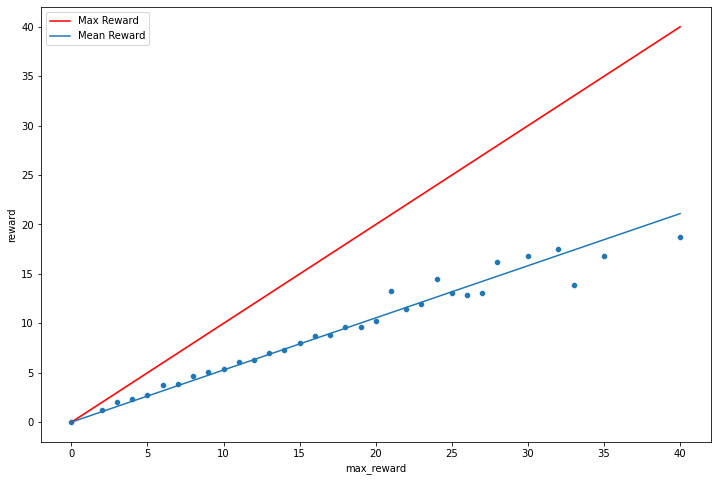

In [32]:
plt.subplots(figsize = (12,8))
g=sns.scatterplot(data=profile.groupby('max_reward').mean().reward.reset_index(), x='max_reward', y='reward')
sns.lineplot(data=profile, x='max_reward', y='max_reward', color='red')
sns.lineplot(x=range(0,41), y=LR.predict(np.array(range(0,41)).reshape(-1,1)))

plt.legend(['Max Reward', 'Mean Reward'])
print(f'Best fit: y={m}x') 

Clustering for big spenders

In [33]:
profile['Male']=profile.gender=='M'
profile['Female']=profile.gender=='F'
profile.drop('gender', axis=1,inplace=True)

In [34]:
profile_pred_dat=profile.copy().drop(['became_member_on', 'big_spender', 'reward', 'max_reward', '#_completed'],axis=1)

In [35]:
profile_pred_dat

,age,income,account_age,spend,#_transactions,Male,Female
id,,,,,,,
ae6f43089b674728a50b8727252d3305,36.0,71000.0,4.0,1257.06,13.0,False,True
ad1f0a409ae642bc9a43f31f56c130fc,66.0,80000.0,4.0,1236.32,4.0,True,False
dce784e26f294101999d000fad9089bb,53.0,110000.0,5.0,1125.96,6.0,False,True
4d0ebb94a5a94fe6afd9350c7b1477e4,81.0,117000.0,5.0,1094.19,6.0,True,False
7d7f271652d244f78b97c73cd734c553,37.0,98000.0,5.0,1085.34,13.0,True,False
...,...,...,...,...,...,...,...
043b6b6be98c412d901f7f376e0548d0,73.0,77000.0,4.0,0.00,0.0,True,False
00e52682848542c3a6f59b7824e9a5c5,40.0,65000.0,5.0,0.00,0.0,True,False
25d81869d43045c09ebf32a6696908e6,75.0,116000.0,4.0,0.00,0.0,True,False


In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [37]:
profile_pred_dat=profile.copy()[['income', '#_transactions']]
profile_pred_dat.income=profile_pred_dat.income.apply(np.log)

In [38]:
profile_pred_dat['prop_spend']=profile.spend/profile.income
profile_pred_dat['mean_spend']=(profile.spend/profile['#_transactions']).fillna(0)

In [39]:
def km(n):
    kmeans_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=n))
    ])
    return kmeans_pipe

In [40]:
inertias=[]

for n in range(1,11):
    kmeans=km(n)
    kmeans.fit(profile_pred_dat)
    inertias.append(kmeans['kmeans'].inertia_)

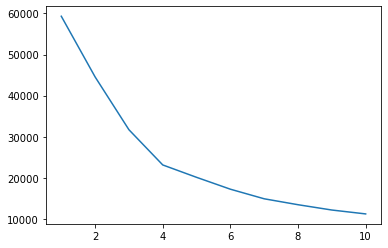

In [41]:
plt.plot(range(1,11),inertias)

In [42]:
kmeans_pipe=Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=4))
])

In [43]:
kmeans_pipe.fit(profile_pred_dat)

Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=4))])

In [44]:
profile['cluster']=kmeans_pipe.predict(profile_pred_dat)

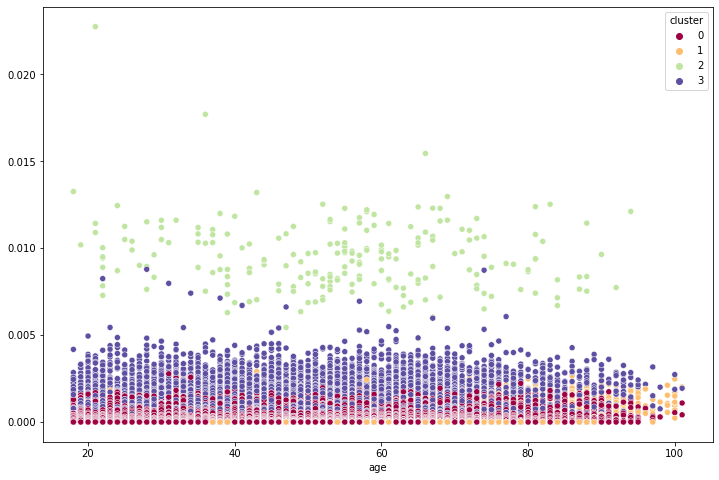

In [45]:
sns.color_palette("Spectral")
plt.subplots(figsize = (12,8))
sns.scatterplot(y=profile.spend/profile.income, x=profile.age, hue=profile.cluster, palette='Spectral');

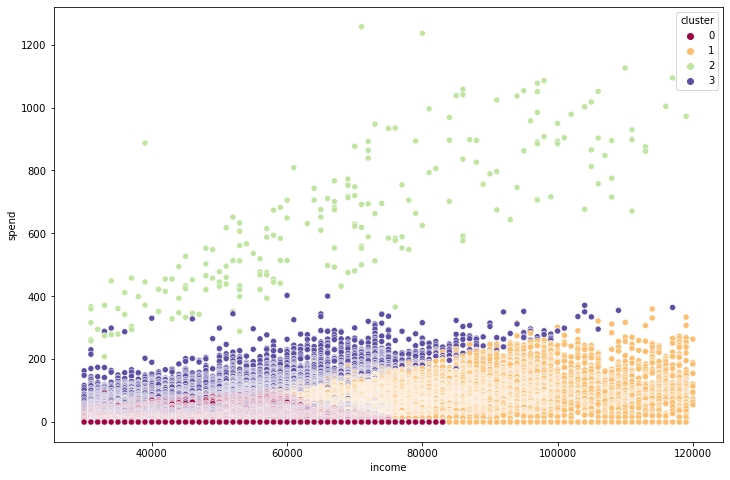

In [46]:
plt.subplots(figsize = (12,8))
sns.scatterplot(data=profile, x='income', y='spend', hue=profile.cluster,palette='Spectral');

In [47]:
profile.big_spender=profile.big_spender.astype(bool)

comparison=profile.groupby('cluster').big_spender.mean().sort_values(ascending=False)
big_spender_cluster=comparison.index[0]
profile.big_spender=(profile.cluster==big_spender_cluster)
comparison

cluster
2    0.875598
3    0.000554
1    0.000000
0    0.000000
Name: big_spender, dtype: float64

In [48]:
profile['mean_spend']=(profile.spend/profile['#_transactions']).fillna(0)

(0.0, 20.0)

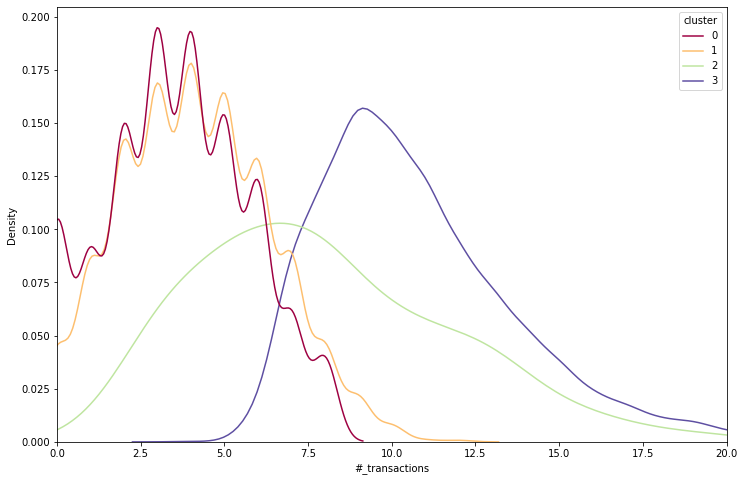

In [49]:
plt.subplots(figsize = (12,8))
g=sns.kdeplot(profile['#_transactions'], hue=profile.cluster, common_norm=False, palette='Spectral')
g.set_xlim(0,20)

(0.0, 100.0)

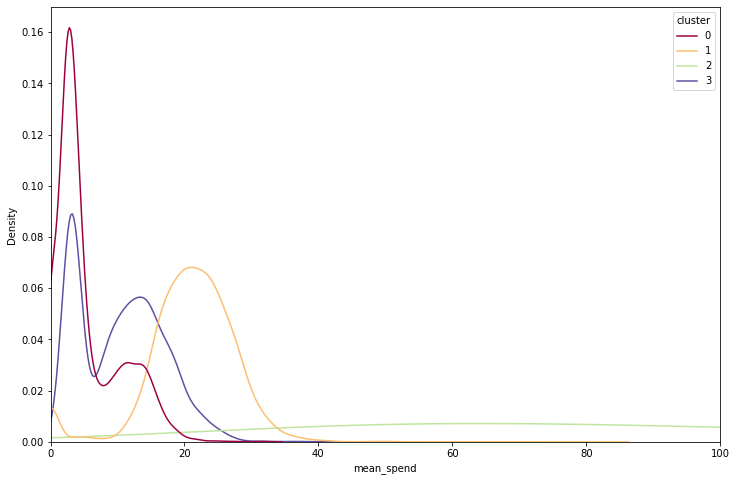

In [50]:
plt.subplots(figsize = (12,8))
g=sns.kdeplot(profile.mean_spend, hue=profile.cluster, common_norm=False, palette='Spectral')
g.set_xlim(0,100)

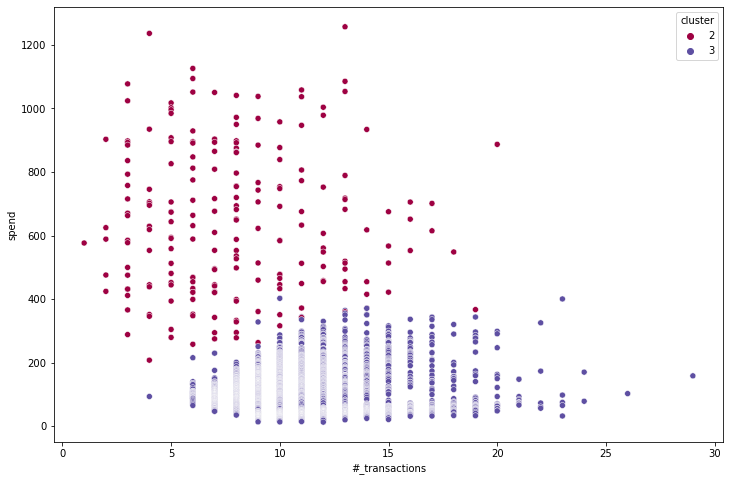

In [51]:
plt.subplots(figsize = (12,8))
g=sns.scatterplot(data=profile[(profile.cluster.apply(lambda x: x in comparison.index[:2]))], y='spend',
                  x= '#_transactions', hue='cluster', palette='Spectral')

Offer Classification

In [52]:
offers_recieved['end']=offers_recieved.time+offers_recieved.duration*24

In [53]:
offers_recieved=offers_recieved[offers_recieved.person.apply(lambda x: x in profile.index)]
offers_viewed=pull_event('offer viewed').set_index(['person', 'offer_id']).sort_index()

In [54]:
transactions=pull_event('transaction', parser=lambda x: x['amount'], label='spend')
offers_completed=offers_completed.merge(transactions, left_on=['person', 'time'], 
                                        right_on=['person', 'time']).set_index(['person', 'offer_id']).sort_index()

In [55]:
test_recieved=pull_event('offer received', df=test_transcript).set_index(['person', 'offer_id']).sort_index()
test_viewed=pull_event('offer viewed', df=test_transcript).set_index(['person', 'offer_id']).sort_index()
test_completed=pull_event('offer completed', df=test_transcript, 
                          parser=lambda x: x['offer_id'])

test_transactions=pull_event('transaction', df=test_transcript, parser=lambda x: x['amount'], label='spend')
test_completed=test_completed.merge(test_transactions, left_on=['person', 'time'], 
                                        right_on=['person', 'time']).set_index(['person', 'offer_id']).sort_index()

test_recieved=test_recieved.merge(portfolio, left_on='offer_id', right_index=True).reset_index()
test_recieved['end']=test_recieved.time+test_recieved.duration*24

In [56]:
def viewed_completed(row, viewed=offers_viewed, completed=offers_completed):
    offer=row.offer_id
    person=row.person
    start=row.time
    end=row.end
    
    def check(df, val=False):
        try:
            passed=df.loc[(person,offer)]
            passed=passed[(passed.time <= end) & (passed.time >= start)]
            #if val:
                #passed=passed.iloc[0,-1]
            #else:
            return int(passed.shape[0] >0 )
        except:
            passed=0
        return passed
    return pd.Series([offer, person, start, check(viewed),check(completed, True)], index=['offer_id', 'person','time','viewed','Completed'])

In [57]:
offer_df=offers_recieved.merge(
    offers_recieved.apply(viewed_completed, axis=1),
    left_on=['offer_id', 'person', 'time'], right_on=['offer_id', 'person', 'time'])

test_vc=test_recieved.apply(lambda row: 
                    viewed_completed(row, viewed=test_viewed, completed=test_completed), axis=1)
test_offer_df=test_recieved.merge(
    test_vc,
    left_on=['offer_id', 'person', 'time'], right_on=['offer_id', 'person', 'time'])

In [58]:
offer_df['offered']=1
test_offer_df['offered']=1

In [59]:
offer_df.head()

,person,time,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web,end,viewed,Completed,offered
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,168,1,1,1
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,168,0,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,168,1,1,1
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,168,1,1,1
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1.0,1.0,0.0,1.0,168,0,0,1


In [60]:
def make_table(df, train_cols=['offered', 'viewed', 'Completed']):
    tables=[]
    table_shapes=[]
    for col in train_cols:
        table=df.pivot_table(col, index=['person', 'time'], columns='offer_id').fillna(0)
        table.columns=[name+'_'+col for name in table.columns]
        tables.append(table)
        table_shapes.append(table.shape)
    return pd.concat(tables, axis=1).reset_index().set_index('person').drop('time', axis=1)

offer_table=make_table(offer_df)
test_offer_table=make_table(test_offer_df)

In [61]:
profile.index.name='person'
profile=pd.get_dummies(profile, columns=['cluster'])

In [62]:
import random
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

In [120]:
def drop_and_merge(cols, profile=profile):
    return lambda table: profile.drop(cols,axis=1).merge(table, 
                    left_index=True, right_index=True, how='right').fillna(0)

profile_train_cols=['spend', 'reward','max_reward', 
                    '#_completed', 'became_member_on', 'cluster_'+str(big_spender_cluster)]



In [129]:
profile.head()

,age,became_member_on,income,account_age,spend,big_spender,reward,max_reward,#_completed,#_transactions,Male,Female,mean_spend,cluster_0,cluster_1,cluster_2,cluster_3
person,,,,,,,,,,,,,,,,,
ae6f43089b674728a50b8727252d3305,36.0,2017-05-21 00:00:00,71000.0,4.0,1257.06,True,17.0,17.0,3.0,13.0,False,True,96.696923,0,0,1,0
ad1f0a409ae642bc9a43f31f56c130fc,66.0,2017-08-27 00:00:00,80000.0,4.0,1236.32,True,15.0,25.0,3.0,4.0,True,False,309.080000,0,0,1,0
dce784e26f294101999d000fad9089bb,53.0,2016-02-03 00:00:00,110000.0,5.0,1125.96,True,9.0,9.0,3.0,6.0,False,True,187.660000,0,0,1,0
4d0ebb94a5a94fe6afd9350c7b1477e4,81.0,2016-01-16 00:00:00,117000.0,5.0,1094.19,True,15.0,15.0,2.0,6.0,True,False,182.365000,0,0,1,0
7d7f271652d244f78b97c73cd734c553,37.0,2016-03-24 00:00:00,98000.0,5.0,1085.34,True,28.0,28.0,4.0,13.0,True,False,83.487692,0,0,1,0


In [66]:
df=pd.concat([offer_table, test_offer_table])

In [68]:
from sklearn.preprocessing import FunctionTransformer

In [70]:
import itertools

In [139]:
col_choices=['#_transactions', 'spend', 'mean_spend']+list(
    profile.drop(profile_train_cols, axis=1).columns[-3:])
col_choices=[[list(x) for x in itertools.combinations(col_choices, k)] for k in range(1,5)]

col_labels=[','.join(x) for x in itertools.chain.from_iterable(col_choices)]
fun_choices=[FunctionTransformer(drop_and_merge(combo+profile_train_cols)) for 
             combo in itertools.chain.from_iterable(col_choices)]

In [140]:
m=df.shape[0]
n=offer_table.shape[0]
train=list(range(0,n))
test=list(range(n,m))

In [141]:
y=df.iloc[:,-20:]
X=df.iloc[:,:-20]
split=[(train,test)]

In [142]:
grid= GridSearchCV(clf_pipe, param_grid=[{'offer_data': fun_choices}], cv=split, 
                   verbose=True, n_jobs=-1, refit=False, scoring='f1_micro')

In [143]:
grid.fit(X,y);

Fitting 1 folds for each of 56 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  3.3min finished


In [144]:
grid_res=pd.DataFrame(grid.cv_results_, index=col_labels).sort_values('rank_test_score')
grid_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_offer_data,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
"#_transactions,spend,cluster_1,cluster_3",36.076089,0.0,5.967483,0.0,FunctionTransformer(func=<function drop_and_me...,{'offer_data': FunctionTransformer(func=<funct...,0.840289,0.840289,0.0,1
"#_transactions,cluster_1,cluster_3",38.761641,0.0,5.165574,0.0,FunctionTransformer(func=<function drop_and_me...,{'offer_data': FunctionTransformer(func=<funct...,0.839199,0.839199,0.0,2
"#_transactions,cluster_0,cluster_1,cluster_3",29.435657,0.0,4.643947,0.0,FunctionTransformer(func=<function drop_and_me...,{'offer_data': FunctionTransformer(func=<funct...,0.836495,0.836495,0.0,3
"#_transactions,cluster_0,cluster_3",37.877697,0.0,6.954428,0.0,FunctionTransformer(func=<function drop_and_me...,{'offer_data': FunctionTransformer(func=<funct...,0.835816,0.835816,0.0,4
"#_transactions,spend,cluster_0,cluster_3",36.498494,0.0,5.993827,0.0,FunctionTransformer(func=<function drop_and_me...,{'offer_data': FunctionTransformer(func=<funct...,0.835403,0.835403,0.0,5


In [146]:
col_choice=grid_res.index[0].split(',')
profile_train_cols+=col_choice

In [147]:
clf_pipe= Pipeline([
    ('offer_data', FunctionTransformer(drop_and_merge(profile_train_cols+['#_transactions', 'mean_spend']))),
    ('clf', MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1))     
])

In [160]:
param_grid={
    'clf__estimator__criterion':['gini', 'entropy'],
    'clf__estimator__min_samples_split':np.logspace(-3,-1,5),
    'clf__estimator__min_samples_leaf':np.logspace(-4,-2,5),
}

In [159]:
clf_pipe.get_params()

{'memory': None,
 'steps': [('offer_data',
   FunctionTransformer(func=<function drop_and_merge.<locals>.<lambda> at 0x000002541196F1F0>)),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(), n_jobs=-1))],
 'verbose': False,
 'offer_data': FunctionTransformer(func=<function drop_and_merge.<locals>.<lambda> at 0x000002541196F1F0>),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(), n_jobs=-1),
 'offer_data__accept_sparse': False,
 'offer_data__check_inverse': True,
 'offer_data__func': <function __main__.drop_and_merge.<locals>.<lambda>(table)>,
 'offer_data__inv_kw_args': None,
 'offer_data__inverse_func': None,
 'offer_data__kw_args': None,
 'offer_data__validate': False,
 'clf__estimator__bootstrap': True,
 'clf__estimator__ccp_alpha': 0.0,
 'clf__estimator__class_weight': None,
 'clf__estimator__criterion': 'gini',
 'clf__estimator__max_depth': None,
 'clf__estimator__max_features': 'auto',
 'clf__estimator__max_leaf_nodes': None,
 'clf__estimator__

In [161]:
grid_2= GridSearchCV(clf_pipe, param_grid=param_grid, cv=2, 
                   verbose=True, n_jobs=-1, scoring='f1_micro')

In [162]:
grid_2.fit(X.iloc[train], y.iloc[train])

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('offer_data',
                                        FunctionTransformer(func=<function drop_and_merge.<locals>.<lambda> at 0x000002541196F1F0>)),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(),
                                                              n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__estimator__criterion': ['gini', 'entropy'],
                         'clf__estimator__min_samples_leaf': array([0.0001    , 0.00031623, 0.001     , 0.00316228, 0.01      ]),
                         'clf__estimator__min_samples_split': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ])},
             scoring='f1_micro', verbose=True)

In [164]:
y_pred=grid_2.predict(X.iloc[test])

In [165]:
print(classification_report(y.iloc[test],y_pred, target_names=y_test.columns, zero_division=0))

                                            precision    recall  f1-score   support

   0b1e1539f2cc45b7b9fa7c272da2e1d7_viewed       0.64      0.18      0.28       870
   2298d6c36e964ae4a3e7e9706d1fb8c2_viewed       0.96      1.00      0.98      2497
   2906b810c7d4411798c6938adc9daaa5_viewed       0.66      0.60      0.63      1316
   3f207df678b143eea3cee63160fa8bed_viewed       0.66      0.57      0.61      1265
   4d5c57ea9a6940dd891ad53e9dbe8da0_viewed       0.95      1.00      0.97      2407
   5a8bc65990b245e5a138643cd4eb9837_viewed       0.81      1.00      0.89      2045
   9b98b8c7a33c4b65b9aebfe6a799e6d9_viewed       0.62      0.61      0.62      1378
   ae264e3637204a6fb9bb56bc8210ddfd_viewed       0.86      1.00      0.93      2181
   f19421c1d4aa40978ebb69ca19b0e20d_viewed       0.95      1.00      0.98      2429
   fafdcd668e3743c1bb461111dcafc2a4_viewed       0.96      1.00      0.98      2463
0b1e1539f2cc45b7b9fa7c272da2e1d7_Completed       0.63      0.75      0.69  

In [167]:
pd.DataFrame(grid_2.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator__criterion,param_clf__estimator__min_samples_leaf,param_clf__estimator__min_samples_split,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
31,13.783573,1.297661,4.985041,0.342651,entropy,0.000316228,0.00316228,"{'clf__estimator__criterion': 'entropy', 'clf_...",0.843964,0.846224,0.845094,0.001130,1
5,15.467811,0.026936,2.522431,0.015014,gini,0.000316228,0.001,"{'clf__estimator__criterion': 'gini', 'clf__es...",0.843376,0.846426,0.844901,0.001525,2
30,11.421481,0.278075,2.339742,0.019195,entropy,0.000316228,0.001,"{'clf__estimator__criterion': 'entropy', 'clf_...",0.843595,0.846162,0.844879,0.001284,3
10,15.333007,0.377595,3.188875,0.240723,gini,0.001,0.001,"{'clf__estimator__criterion': 'gini', 'clf__es...",0.843136,0.845446,0.844291,0.001155,4
35,13.418784,0.288059,3.192003,0.485498,entropy,0.001,0.001,"{'clf__estimator__criterion': 'entropy', 'clf_...",0.843166,0.845331,0.844249,0.001083,5
1,12.976843,0.176160,2.286570,0.007210,gini,0.0001,0.00316228,"{'clf__estimator__criterion': 'gini', 'clf__es...",0.842742,0.845755,0.844248,0.001506,6
6,13.248611,0.149998,2.395985,0.190674,gini,0.000316228,0.00316228,"{'clf__estimator__criterion': 'gini', 'clf__es...",0.843049,0.845108,0.844079,0.001029,7
26,14.129409,1.472773,3.508447,0.412760,entropy,0.0001,0.00316228,"{'clf__estimator__criterion': 'entropy', 'clf_...",0.842331,0.845760,0.844046,0.001714,8
36,13.215355,0.651955,2.845231,0.240233,entropy,0.001,0.00316228,"{'clf__estimator__criterion': 'entropy', 'clf_...",0.842694,0.844627,0.843660,0.000967,9
11,14.507700,0.006620,3.139005,0.257995,gini,0.001,0.00316228,"{'clf__estimator__criterion': 'gini', 'clf__es...",0.842562,0.844716,0.843639,0.001077,10


In [ ]:
clf_pipe.fit(X,y);

In [ ]:
y_pred=clf_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred, target_names=y_test.columns, zero_division=0))

In [ ]:
pd.Series(['ae6f43089b674728a50b8727252d3305'])

In [ ]:
df

In [ ]:
def offer_decision(person, results=False):
    try_df=pd.DataFrame(np.diag([1]*10), columns=[offer+'_offered' for offer in portfolio.index], index=[person]*10)
    #try_df=try_df.append(pd.Series([0]*10, name=person, index=[offer+'_offered' for offer in portfolio.index]))
    try_df=df.merge(try_df, left_index=True, right_index=True)
    
    guess=pd.DataFrame(RFR.predict(try_df), columns=y.columns)
    guess=pd.concat([guess.sum(axis=1)], axis=1)
    guess.columns=['completed']
    guess.index=list(portfolio.index)
    guess=guess.join(portfolio[['reward', 'difficulty']]).fillna(0)

    IV=guess.completed-guess.reward
    disc=IV.sort_values().index[-1]
    if results:
        return IV
    
    if IV.loc[disc] > 0:
        return disc
    return ''

In [ ]:
offer_decision('ffff82501cea40309d5fdd7edcca4a07', True)

In [ ]:
decisons=[offer_decision(person) for person in profile.index]

In [ ]:
decisions=pd.Series(decisions, index=profile.index)